# Metropolis of 2d Ising model 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [3]:
from matplotlib import animation

In [4]:
import copy
import time

In [113]:
class ISING_2D:
    def __init__(self, j=1, beta=1, h=1, dims=(5, 5), delta=1, seed=0):
        np.random.seed(seed)
        self.dims = dims
        self.delta = delta
        self.beta = beta
        self.j = j
        self.h = h
        self.grids = (-1) ** np.reshape(np.random.binomial(1, 1/2, dims[0]*dims[1]), dims)
        
    def neibor_get(self, id_grid):
        height, width = self.dims
        x_index, y_index = id_grid
        l_neibor = ((x_index - 1) % width, y_index)
        r_neibor = ((x_index + 1) % width, y_index)
        u_neibor = (x_index, (y_index - 1) % height)
        d_neibor = (x_index, (y_index + 1) % height)           
        ur_neibor = ((x_index + 1) % width, (y_index + 1) % height)
        dl_neibor = ((x_index - 1) % width, (y_index - 1) % height)
        return [l_neibor, r_neibor, u_neibor, d_neibor, ur_neibor, dl_neibor]
        
    def one_step_mcmc(self):
        id_random = np.random.randint(self.dims[0]*self.dims[1])
        id_height, id_width = id_random // self.dims[1], id_random % self.dims[1]
        spin_old = self.grids[id_height][id_width]
        spin_new = spin_old * np.random.choice([-1, 1], 1, p=[self.delta, 1-self.delta])[0]
        energy_old = self.energy_compute_one_grid((id_height, id_width), spin_old)
        energy_new = self.energy_compute_one_grid((id_height, id_width), spin_new)
        energy_delta = energy_new - energy_old
        if energy_delta <= 0:
            self.grids[id_height][id_width] = spin_new
            return energy_new
        else:
            prob_accept = min(np.exp(-self.beta * energy_delta), 1)
            if np.random.uniform(0, 1) < prob_accept:
                self.grids[id_height][id_width] = spin_new
                return energy_new
            else:
                return energy_old
            
    def mcmc(self, step, show_energy=False, show_plot=False, period=100, store_period=100, energy_accumu=False, folder_name=None):
        energy_list, spins_list = [], []
        for i in range(step):
            self.one_step_mcmc()
            energy_total = self.energy_compute_grids()
            energy_list.append(energy_total)
            print_template = "Step: {step} Energy: {energy}\t"
            if show_energy:
                print(print_template.format(step=i+1, energy=energy_total))  
            if show_plot and i % period == 0:
                self.spin_viz(save=True, step=i, folder_name=folder_name)
            if i % store_period == 0:
                spins_list.append(self.grids.copy())
        if energy_accumu:
            return np.mean(energy_list), spins_list
        else:
            return spins_list
        
    def spin_viz_dynamic(self, spins_list, file_name, figsize=(10, 3)):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.length), 0)
        u = np.cos(spins_list[0])
        v = np.sin(spins_list[0])
        q = plt.quiver(x, y, u, v, scale=20, width=0.01, headlength=3, headwidth=2, headaxislength=3, minshaft=3)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.length), fontsize=20)            
        def update_quiver(num, q):
            u = np.cos(spins_list[num+1])
            v = np.sin(spins_list[num+1])
            q.set_UVC(u, v)
            return q
        frames = len(spins_list) - 1
        self.anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                       fargs=(q, ), interval=50, repeat=False)
        writergif = animation.PillowWriter(fps=100) 
        self.anim.save(f'./{file_name}.gif', writer=writergif)
        
    def spin_viz(self, figsize=(10, 10), save=False, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.dims[0]), np.arange(0, self.dims[1]))
        u = np.cos(self.grids*np.pi/2)
        v = np.sin(self.grids*np.pi/2)
        q = plt.quiver(x, y, u, v)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.dims), fontsize=20)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
            plt.close(fig)
            
    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.dims[0]):
            for j in range(self.dims[1]):
                id_neibors = self.neibor_get((i, j))
                energy_ij = 0
                for ij in id_neibors:
                    energy_ij = -self.j * self.grids[ij[0]][ij[1]] * self.grids[i][j]
                energy_total += energy_ij
                ### compute the energy of external field
                energy_total += -self.h * self.grids[i][j]
        energy_per_spin = energy_total / (self.dims[0] * self.dims[1])
        return energy_per_spin
    
    def energy_compute_one_grid(self, id_grid, id_spin):
        id_neibors = self.neibor_get(id_grid)
        id_energy = 0
        for neibor in id_neibors:
            id_energy += -self.j * self.grids[neibor[0]][neibor[1]] * id_spin
        id_energy += -self.h * id_spin
        return id_energy
    
    def magnet_grids(self):
        magnet_x, magnet_y = 0, 0
        for i in range(self.length):
            magnet_x += np.sin(self.grids[i])
            magnet_y += np.cos(self.grids[i])
        return magnet_x, magnet_y

In [94]:
# initialize the 1d xy model
dims = (5, 5)
ising_2d = ISING_2D(dims=dims, beta=100, j=1, h=0, delta=1)

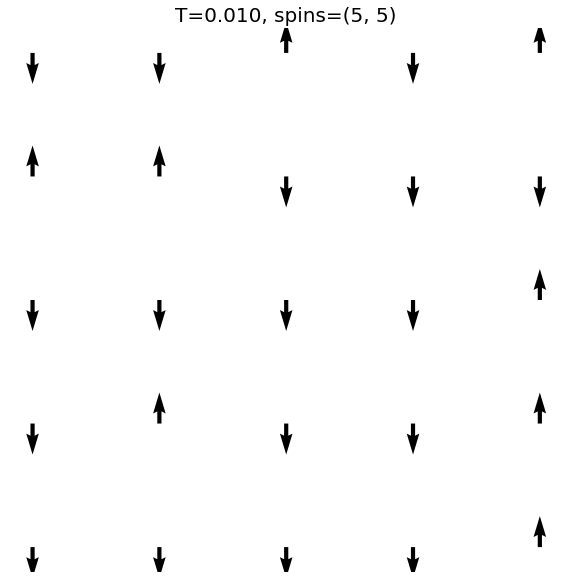

In [95]:
ising_2d.spin_viz()

In [96]:
# burning-in stage
ising_2d.mcmc(100000, show_energy=False)
print('mcmc is done!')

mcmc is done!


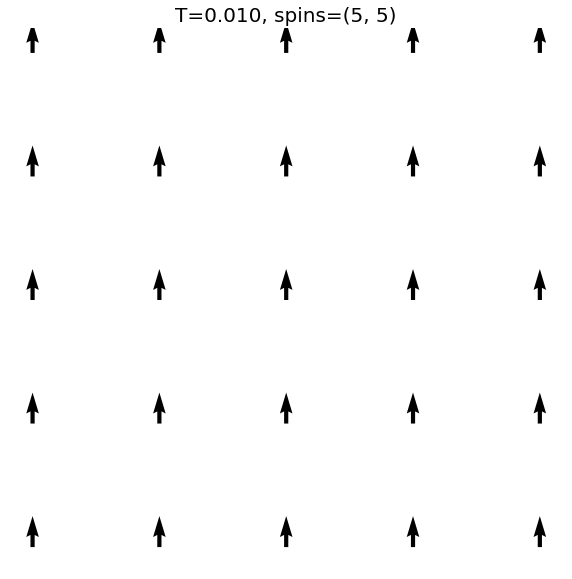

In [97]:
ising_2d.spin_viz()

In [98]:
### sampling stage
energy_list = []
for i in trange(100000):
    ising_2d.one_step_mcmc()
    energy_list.append(ising_2d.energy_compute_grids())
print("iterations are done!")

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


In [99]:
np.mean(energy_list)

-1.0

In [102]:
np.std(energy_list)

0.0

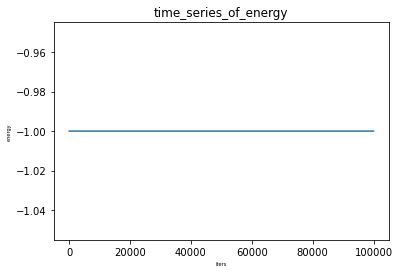

In [103]:
plt.title('time_series_of_energy')
plt.xlabel('iters', fontsize=5)
plt.ylabel('energy', fontsize=5)
plt.plot(energy_list)

----
### High temperature 

In [104]:
# initialize the 1d xy model
dims = (5, 5)
ising_2d = ISING_2D(dims=dims, beta=1, j=1, h=0, delta=1)

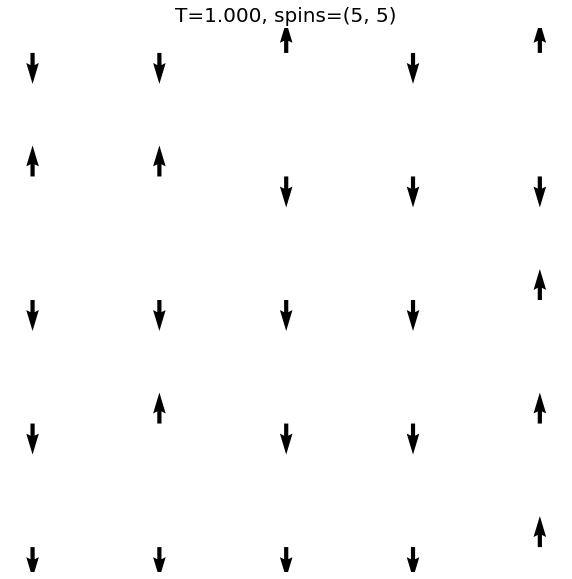

In [105]:
ising_2d.spin_viz()

In [106]:
# burning-in stage
ising_2d.mcmc(100000, show_energy=False)
print('mcmc is done!')

mcmc is done!


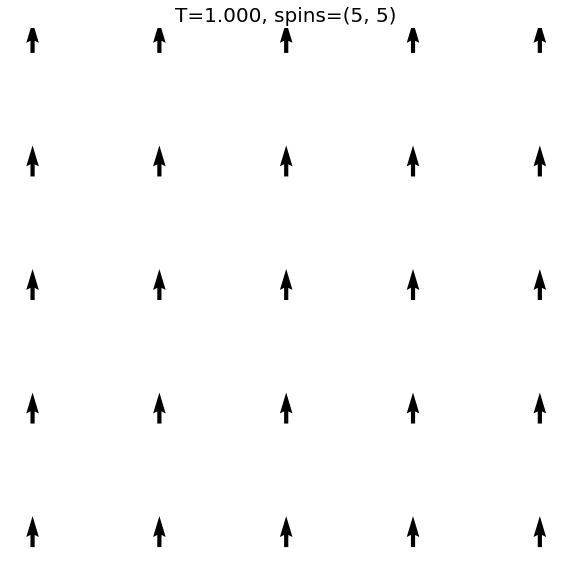

In [107]:
ising_2d.spin_viz()

In [108]:
### sampling stage
energy_list = []
for i in trange(100000):
    ising_2d.one_step_mcmc()
    energy_list.append(ising_2d.energy_compute_grids())
print("iterations are done!")

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


In [109]:
np.mean(energy_list)

-0.9999888

In [110]:
np.std(energy_list)

0.0013386091886730795

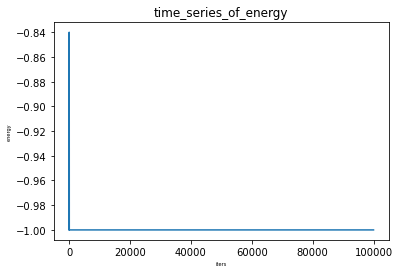

In [111]:
plt.title('time_series_of_energy')
plt.xlabel('iters', fontsize=5)
plt.ylabel('energy', fontsize=5)
plt.plot(energy_list)

-----
### External field h = 0

In [121]:
beta_list = [0.05 * i for i in range(1, 11)]
temp_list = [1 / beta for beta in beta_list]
dims = (5, 5)

In [122]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(100000):
        ising_2d.one_step_mcmc()
    ### Sampling stage
    energy_list = []
    for i in trange(100000):
        ising_2d.one_step_mcmc()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

iterations are done!


In [123]:
mean_sampling_list

[-0.058052800000000016,
 -0.1252656,
 -0.21753920000000004,
 -0.38553439999999994,
 -0.6198271999999999,
 -0.8170496,
 -0.9163679999999997,
 -0.9570848,
 -0.9789520000000002,
 -0.9886192000000001]

In [124]:
std_sampling_list

[0.2012860661152679,
 0.20705613117374716,
 0.2195736060262253,
 0.26263311751688895,
 0.2773019187459041,
 0.19853446839236755,
 0.1301661422029554,
 0.09032251994358882,
 0.060255370681790696,
 0.043797504396483604]

In [132]:
energy_metropolis_list = [-0.051888,
                          -0.10681600000000001,
                          -0.187264,
                          -0.32660800000000006,
                          -0.548512,
                          -0.7941919999999999,
                          -0.8984639999999999,
                          -0.949824,
                          -0.9734879999999999,
                          -0.985568]

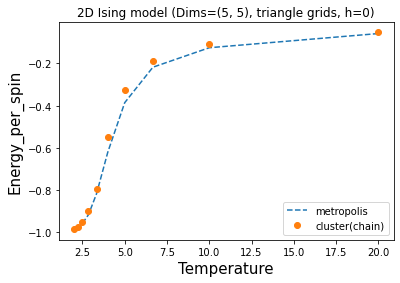

In [133]:
plt.plot(temp_list, mean_sampling_list, '--', label='metropolis')
plt.plot(temp_list, energy_metropolis_list, 'o', label='cluster(chain)')
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Energy_per_spin', fontsize=15)
plt.legend()
plt.title('2D Ising model (Dims=(5, 5), triangle grids, h=0)')
plt.savefig('./2d_ising_cluster_chain.pdf', dpi=100)